In [1]:
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [2]:
pdbbind_training_set_pk = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
pdbbind_training_set = pdbbind_training_set_pk.index

docked_pose_features = pd.read_csv('../data/docked_pose_features.csv', index_col=0)

feature_sets = {}
with open('../data/lb_feature_names.txt') as f:
    feature_sets['LB'] = pd.Index([l.strip() for l in f])
with open('../data/sb_feature_names.txt') as f:
    feature_sets['SB'] = pd.Index([l.strip() for l in f])
with open('../data/hb_feature_names.txt') as f:
    feature_sets['HB'] = pd.Index([l.strip() for l in f])

# We've enumerated the docked poses associated to each PDB structure - these labels are used for cross-validation later
with open('../data/docked_pose_labels.json') as f:
    docked_pose_labels = json.load(f)

In [3]:
# do feature importance - want to use multiple training poses

feature_importance_top_dock = {}
feature_importance_all_docks = {}
feature_importance_redundant_docks = {}

for model in feature_sets:

    # top pose
    top_pose_labels = pdbbind_training_set.map(lambda x: x+'_0')
    X_train = docked_pose_features.loc[top_pose_labels, feature_sets[model]].values
    y_train = pdbbind_training_set_pk.loc[pdbbind_training_set].values.ravel()
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, n_jobs=6, random_state=42)
    rf.fit(X_train, y_train)
    feature_importance_top_dock[model] = pd.Series(data=rf.feature_importances_, index=feature_sets[model])
    
    # all poses
    training_pose_labels = []
    for pdb in pdbbind_training_set:
        training_pose_labels.extend(docked_pose_labels[pdb])
    training_pose_pdbs = pd.Index([i[:4] for i in training_pose_labels])
    X_train = docked_pose_features.loc[training_pose_labels, feature_sets[model]].values
    y_train = pdbbind_training_set_pk.loc[training_pose_pdbs].values.ravel()
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, n_jobs=6, random_state=42)
    rf.fit(X_train, y_train)
    feature_importance_all_docks[model] = pd.Series(data=rf.feature_importances_, index=feature_sets[model])
    
    # redundant poses
    training_pose_labels = []
    for pdb in pdbbind_training_set:
        training_pose_labels.extend(docked_pose_labels[pdb])
    training_pose_labels = pd.Index(training_pose_labels).map(lambda x: x[:4]+'_0')
    training_pose_pdbs = pd.Index([i[:4] for i in training_pose_labels])
    X_train = docked_pose_features.loc[training_pose_labels, feature_sets[model]].values
    y_train = pdbbind_training_set_pk.loc[training_pose_pdbs].values.ravel()
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, n_jobs=6, random_state=42)
    rf.fit(X_train, y_train)
    feature_importance_redundant_docks[model] = pd.Series(data=rf.feature_importances_, index=feature_sets[model])

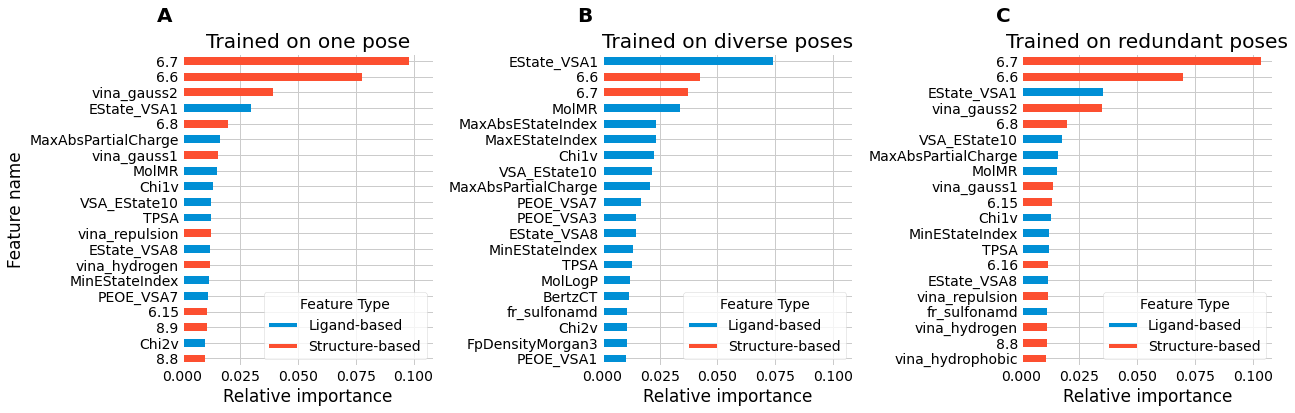

In [5]:
fig, (ax1, ax2, ax3)= plt.subplots(1,3, figsize=(18,6), sharex=True)

colour_dict = {}
for f in feature_sets['LB']:
    colour_dict[f] = '#008fd5'
for f in feature_sets['SB']:
    colour_dict[f] = '#fc4f30'

to_plot = feature_importance_top_dock['HB'].sort_values(ascending=True).tail(20)
colours = [colour_dict[f] for f in to_plot.index]
to_plot.plot.barh(ax=ax1, color=colours)

to_plot = feature_importance_all_docks['HB'].sort_values(ascending=True).tail(20)
colours = [colour_dict[f] for f in to_plot.index]
to_plot.plot.barh(ax=ax2, color=colours)

to_plot = feature_importance_redundant_docks['HB'].sort_values(ascending=True).tail(20)
colours = [colour_dict[f] for f in to_plot.index]
to_plot.plot.barh(ax=ax3, color=colours)

ax1.set_title('Trained on one pose')
ax2.set_title('Trained on diverse poses')
ax3.set_title('Trained on redundant poses')
ax1.set_xlabel('Relative importance')
ax2.set_xlabel('Relative importance')# I like the fivethirtyeight style sheet.

ax3.set_xlabel('Relative importance')

ax1.set_ylabel('Feature name')
fig.tight_layout()

# Legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#008fd5', lw=4),
                Line2D([0], [0], color='#fc4f30', lw=4)]
ax1.legend(custom_lines, ['Ligand-based', 'Structure-based'], title='Feature Type', loc='lower right')
ax2.legend(custom_lines, ['Ligand-based', 'Structure-based'], title='Feature Type', loc='lower right')
ax3.legend(custom_lines, ['Ligand-based', 'Structure-based'], title='Feature Type', loc='lower right')

for ax, annotation in zip((ax1,ax2,ax3), ['A', 'B', 'C']):
    ax.text(-0.1, 1.1, annotation, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()

fig.savefig('../figures/hb_feature_importance.png', dpi=350, bbox_inches='tight')